### A Tale of Two Times
**BLUF:** Logging delay to Splunk as little as 100ms can cause alerts to be missed. This post talks about this issue, detection, and offers a solution.

Splunk is a powerful platform for collecting, indexing, and analyzing data from various sources. However, it is critically important to understand the nuances of how Splunk handles time; forgoing such consideration may lead to missing critical events. 

#### _time
The `_time` field in Splunk represents the timestamp of an event as specified by the source log. This field is critical for time-based analysis, such as identifying trends, detecting anomalies, and correlating events across different sources. This is the time that is visualized by Splunk when viewing search results, and is used as the time variable when performing searches.

#### _indextime
The `_indextime` field in Splunk represents the timestamp when the event is indexed by Splunk, which may not always be the same as the `_time` field. Simply, this is the time Splunk logged the event, the time it becomes avaiable in search, and it will almost always differ from `_time`, even if by miliseconds. 

### A Wrinkle in Time

Why do the times differ? 

Truth is, there is delay, there are many points in the ingestion pipeline that can cause delay such as:
* Network latency
* Logging throughput capacity
* Logging interval 
* Clock skew

The issue with timing delays in Splunk is that it can cause alerts to be missed, which can have serious consequences for security and other critical operations. 

For instance, if an alert is monitoring a critical system, but there is a delay between the `_time` and `_indextime` timestamps, **the alert may not be triggered even when events occur.**

### Small Delay = Big Problem

How much delay can cause events to be missed? 

This is a question that many previous discussions on this topic fail to address. While many may note delays of days, hours, or minutes, causing issue; it is important to note that **delays of milliseconds can result in missed events**. In testing, delays as little as 100ms resulted in missed events, and theoretically, the number may even be lower. This raises an important question - are you confident that all of your critical logging sources consistently log in near real-time?

### Delay Detection

**Can I calculate delays in my log sources?**

Yes, Splunk has a great article on this: [here](https://docs.splunk.com/Documentation/Splunk/9.0.4/Troubleshooting/Troubleshootingeventsindexingdelay). 

TL;DR To discover log delays subtract `_time` from `_indextime`.

`index=example_delay | eval delay_sec=_indextime-_time | eval delay_minute=(delay_sec/60) | timechart span=1h avg(delay_minute) by index`

![](splunk_blog_1.png "Fig 1. Example Timechart for Splunk Search")
_Fig 1. Example Timechart for Splunk Search_

**Can I discover if any of my recent saved searches missed events?**

Yes, a simple method is to re-run the same search and compare the results, if the results differ over the same time period, there is likely a timing issue. 

Below is an example script in python to identify saved searches with timing issues. For information on usage go: [here](#link).
I've run this script against an lab instance of Splunk with intentially induced delays, the results are below. 


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
 _____  _____       _____  _   _   _____  _____ _____ _____ _____ _____ _____ _    _ _____
 |    \ |____ |     |___|   \_/    |    \ |____   |   |____ |       |     |    \  /  |____
 |____/ |____ |____ |   |    |     |____/ |____   |   |____ |_____  |   __|__   \/   |____
                                 Splunk Log Delay Detector                            v1.0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Connected to Splunk instance: 192.168.42.138
------------------------------------------------------------------------------------------
SEARCH: indextime_demo SID: scheduler__splunk__search__RMD51aafb4f9eda25a49_at_1680733200_806
RESULT: DIFFERENCE FOUND
NOTE: This is ind

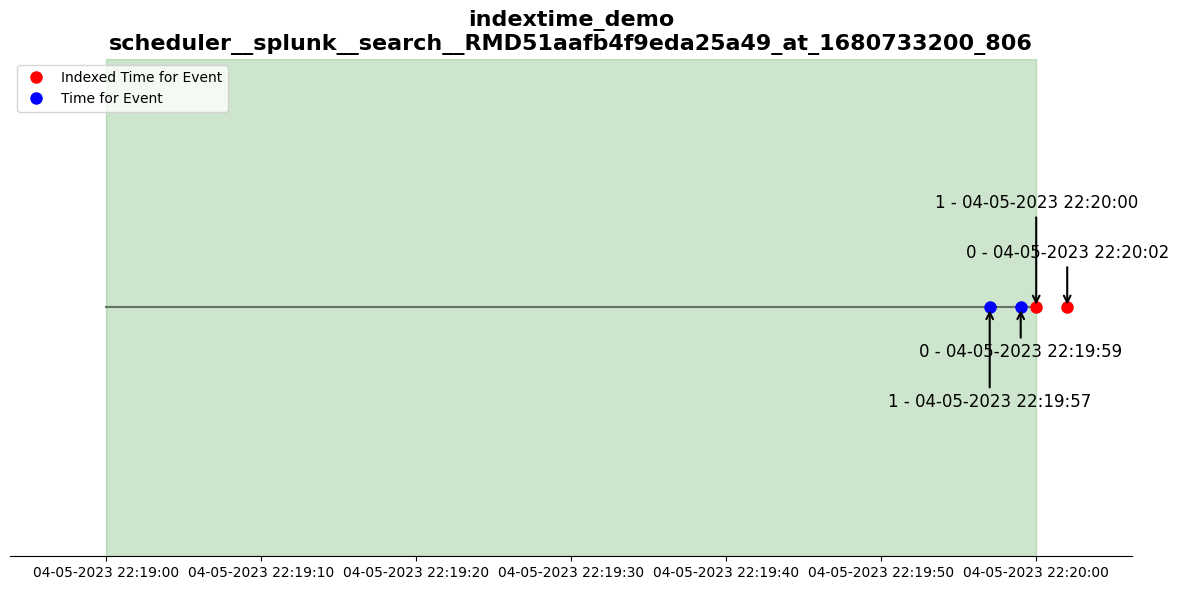

------------------------------------------------------------------------------------------
SEARCH: indextime_demo SID: scheduler__splunk__search__RMD51aafb4f9eda25a49_at_1680566280_768
RESULT: NO DELAY FOUND
NOTE: Search results in original search and re-ran search match, no delay issue identified.
------------------------------------------------------------------------------------------


In [ ]:
#Code to detect and graph differences in recently ran searches

# Import required libraries
import time
import json
import splunklib.client as client
import splunklib.results as results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


# Function to connect to the Splunk service
def splunk_connect(base_url, port, splunk_account, splunk_password):

    try:
        # Connect to the Splunk service
        service = client.connect(host=base_url, port=port, username=splunk_account, password=splunk_password)
        print('Connected to Splunk instance: {}'.format(base_url))
        print('-' * 90)
    except Exception as e:
        print('Error in Connecting to Splunk: {}'.format(e))
    
    # Return the service object
    return service


# Function to compare jobs
def compare_jobs(service,owner,graph):
    
    # Get the list of search jobs
    search_jobs = service.jobs.list()
    
    # Loop through the search jobs
    for job in search_jobs:
        # If the job is a saved search and the owner matches the specified owner
        if job['content']['isSavedSearch'] == '1' and job['access']['owner'] == owner:
     
            # Initialize lists to store results
            results_list = []
            results_list_new = []
            
            # Set the keyword arguments for the search job
            kwargs =    {"earliest_time": job['content']['earliestTime'],
                         "latest_time": job['content']['latestTime'],
                         "search_mode": "normal",
                         "output_mode": "json"}
                
            # Get the results of the original job
            job_results = job.results(output_mode='json')
            
            # Parse the results and append them to the results list
            for x in results.JSONResultsReader(job_results):
                results_list.append(dict(x))
                    
            # Create a new job with the same search criteria
            job_new = service.jobs.create(job['content']['eventSearch'],**kwargs)
            
            # Wait for the new job to finish
            while not job_new.is_done():
                time.sleep(1)
                    
            # Get the results of the new job
            job_results_new = job_new.results(output_mode='json')
            
            # Parse the results and append them to the new results list
            for y in results.JSONResultsReader(job_results_new):
                results_list_new.append(dict(y))
                
            # Compare the lengths of the results lists
            if(len(results_list) != len(results_list_new)):
                # Initialize lists to store issues
                search_issue = []
                results_indexed = []
                results_time = []
                # Add the search issue to the list
                search_issue.append({
                    'sid': job['content']['sid'],
                    'label': job['content']['label'],
                    'earliest_time': job['content']['earliestTime'],
                    'latest_time': job['content']['latestTime'],
                })
                    
                # Get the unique keys for the results
                results_keys = [(d.get('_raw'), d.get('_indextime'), d.get('_time')) for d in results_list]
                results_keys_new = [(d.get('_raw'), d.get('_indextime'), d.get('_time')) for d in results_list_new]
                
                # Find the unique results in the new results list
                unique_to_new = set(results_keys_new) - set(results_keys)

                # print the unique results
                if unique_to_new:
                    print('SEARCH: {} SID: {}'.format(job['content']['label'],job['content']['sid']))
                    print('RESULT: DIFFERENCE FOUND')
                    print('NOTE: This is indicative of a delay issue and resulted in missing events in the original search.')
                    print('-' * 10)
                    print('List of Missing Results')
                    print('-' * 10)
                    
                    #format time and set in index
                    for key in unique_to_new:
                        formatted_indextime = datetime.utcfromtimestamp(int(key[1])).strftime('%Y-%m-%d %H:%M:%S')
                        results_indexed.append(formatted_indextime)
                        formatted_time = datetime.fromisoformat(key[2]).strftime('%Y-%m-%d %H:%M:%S')
                        results_time.append(formatted_time)
                        print('        _time={},_indextime={},_raw={}'.format(formatted_time,formatted_indextime,key[0]))
                    
                    #graph the results    
                    if graph == 'true':     
                        plot_timeline(search_issue,results_indexed,results_time)
                    print('-' * 90)
            else:
                print('SEARCH: {} SID: {}'.format(job['content']['label'],job['content']['sid']))
                print('RESULT: NO DELAY FOUND')
                print('NOTE: Search results in original search and re-ran search match, no delay issue identified.')
                print('-' * 90)
 

# Function to plot the timeline of the search issue
def plot_timeline(search_issue, results_indexed, results_time):
    
    # Convert result issue timestamps to datetime objects
    indextimes = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in results_indexed]
    times = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in results_time]
    # Set the title and subtitle for the plot
    title = search_issue[0]['label']
    subtitle = search_issue[0]['sid']
    
    # Get the start and end dates of the search issue and remove timezone and microseconds
    start_date = datetime.strptime(search_issue[0]['earliest_time'], '%Y-%m-%dT%H:%M:%S.%f%z')
    start_date = start_date.replace(microsecond=0, tzinfo=None)
    end_date = datetime.strptime(search_issue[0]['latest_time'], '%Y-%m-%dT%H:%M:%S.%f%z')
    end_date = end_date.replace(microsecond=0, tzinfo=None)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the base timeline
    ax.plot([start_date, end_date], [0, 0], color='black', alpha=0.5)
    # Fill the area between the start and end dates
    ax.fill_between([start_date, end_date], -0.5, 0.5, color='green', alpha=0.2)

    # Calculate the maximum difference between indextime and start_time
    max_difference = max([abs((date - start_date).total_seconds()) for date in indextimes] +
                         [abs((date - end_date).total_seconds()) for date in indextimes])
    
    # Set the buffer based on the maximum difference
    buffer = timedelta(seconds=max_difference * 0.1)

    # Set the x and y limits for the plot
    ax.set_xlim(start_date - buffer, end_date + buffer)
    ax.set_ylim(-0.5, 0.5)

    # Remove spines and y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_visible(False)

    # Plot the indexed markers and annotations
    for idx, date in enumerate(indextimes):
        ax.plot(date, 0, 'ro', markersize=8, label='Indexed Time for Event')
        ax.annotate('{} - {}'.format(idx,date.strftime('%m-%d-%Y %H:%M:%S')), xy=(date, 0), xytext=(date, 0.1 + (idx % 2) * 0.1),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=12, ha='center')
        
    #plot the time markers and annotations
    for idx, date in enumerate(times):
        ax.plot(date, 0, 'bo', markersize=8, label='Time for Event')
        ax.annotate('{} - {}'.format(idx,date.strftime('%m-%d-%Y %H:%M:%S')), xy=(date, 0), xytext=(date, -0.1 + (idx % 2) * -0.1),
                arrowprops=dict(arrowstyle='->', lw=1.5),
                fontsize=12, ha='center')

    # Set the title, x-axis formatter, and x-axis locator
    ax.set_title('{}\n{}'.format(title,subtitle), fontsize=16, fontweight='bold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y %H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # Create the legend and display unique items
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def banner():
    print('-' * 90)
    print('-' * 90)
    print(' _____  _____       _____  _   _   _____  _____ _____ _____ _____ _____ _____ _    _ _____')
    print(' |    \ |____ |     |___|   \_/    |    \ |____   |   |____ |       |     |    \  /  |____')
    print(' |____/ |____ |____ |   |    |     |____/ |____   |   |____ |_____  |   __|__   \/   |____')
    print('                                 Splunk Log Delay Detector                            v1.0')
    print('-' * 90)
    print('-' * 90)
    
    
def main():
    
    #get config
    with open('config.json') as f:
        data = json.load(f)
        splunk_account = data['splunk_account']
        splunk_password = data ['splunk_password']
        base_url = data['base_url']
        port = data['port']
        owner = data['owner']
        graph = data['graph']
  
    #show banner
    banner()
  
    #connect to splunk
    service = splunk_connect(base_url, port, splunk_account, splunk_password)
    
    #check and compare all jobs by owner
    compare_jobs(service,owner,graph) 
    
    
if __name__ == "__main__":
    main()

### A Solution

Rather than telling Splunk to alert to items within the last `_time` window for our searches, we can alert to anything indexed in the time period since our search last ran. This is instead saying, "Splunk tell me about any log that you just discovered". 

The alert needs to be modified in two ways:

1. Update the Alert Query
2. Update the Time Window

#### Update Alert Query

Splunk can use time modifiers in the search query ([ref](https://docs.splunk.com/Documentation/SCS/current/Search/Timemodifiers)). To switch to `_indextime` alerting we will need to add `_index_earliest` and `_index_latest` to our search query. This will define the `_indexedtime` range we intend to search. 

`_index_earliest` - In most cases, this should be set to the time interval the alert looksback on. (e.g. `_index_earliest=-15m`) \

`_index_latest` - In most cases, this should be set to the current time. (e.g. `_index_latest=now()`)

#### Update Time Window

Switching to `_indextime` alerting will not remove the use of `_time`; it is still a filter on the search. Instead, we need to set the `_time` window to the maximum delay we still want to alert on. 

#### An Example

The below search is updated to alert on `_indextime` alerting. The figure is marked relative to behavior referenced in the list:

1. Search every 15 minutes
2. Search everything indexed within the last 15 minutes 
3. Search everything with _time within the last 14 days*

*This does not significantly impact processing, it is not the same as processing 14 days of data

![](splunk_blog_2.png "Fig 2. Example Updated Splunk Alert") 
_Fig 2. Example Updated Splunk Alert_

This alerts runs every 15 minutes, searching logs indexed in the last 15 minutes, and searching logs that Splunk believes are up to 14 days delayed. 

Simply using `_time` can cause issues with saved searches, even in logs are delayed by minimal amounts. Switching to `_indextime` alerting reduces this problem significantly and I would recommend running all of the saved searches you can with this method. 